In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
from network import MyNetwork
from evaluate import test_pair

### Define some functions

In [2]:
def match(im_1, im_2, n_kp = 2000):
    sift = cv2.xfeatures2d.SIFT_create(
    nfeatures=n_kp, contrastThreshold=1e-5)
    
    cv_kp_1, cv_desc_1 = sift.detectAndCompute(im_1, None)
    cv_kp_2, cv_desc_2 = sift.detectAndCompute(im_2, None)
    
    matcher = cv2.BFMatcher(cv2.NORM_L2)
    matches_all = matcher.match(cv_desc_1, cv_desc_2)
    
    scores=np.array([x.distance for x in matches_all])
    idx1 = np.array([x.queryIdx for x in matches_all])
    idx2 = np.array([x.trainIdx for x in matches_all])
    
    kp1_x = np.array([k.pt[0] for k in cv_kp_1])[idx1]
    kp1_y = np.array([k.pt[1] for k in cv_kp_1])[idx1]
    kp1 = np.stack((kp1_x,kp1_y),axis=1)

    kp2_x = np.array([k.pt[0] for k in cv_kp_2])[idx2]
    kp2_y = np.array([k.pt[1] for k in cv_kp_2])[idx2]
    kp2 = np.stack((kp2_x,kp2_y),axis=1)

    return kp1, kp2, scores

In [3]:
def run_model(mynet, kp1, kp2, shape_im_1, shape_im_2):
    # normalize coordinates
    kp1 = (kp1-0.5*np.array(shape_im_1[:2])[::-1])/np.max(shape_im_1[:2])
    kp2 = (kp2-0.5*np.array(shape_im_2[:2])[::-1])/np.max(shape_im_2[:2])
    # concatenate
    xs = np.expand_dims(np.concatenate((kp1,kp2),axis=1),0)
    # run
    ys = test_pair(mynet, xs)
    return ys

### Load model

In [4]:
with open('./demo/config.pickle', 'rb') as handle: config = pickle.load(handle)

In [5]:
mynet = MyNetwork(config);

Building Graph
(?, 1, ?, 4)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, 1, ?, 128)
(?, ?)
X shape = (?, ?, 9)
wX shape = (?, ?, 9)
XwX shape = (?, 9, 9)


In [6]:
mynet.load_model()

Restoring from ./models/models-best...
INFO:tensorflow:Restoring parameters from ./models/models-best
Model File ./models/models-best loaded!


### Load images

In [7]:
im_1=cv2.imread('./demo/reichstag1.jpg')
im_2=cv2.imread('./demo/reichstag2.jpg')

### Run model

In [8]:
# get initial matches 
kp1, kp2, _=match(im_1, im_2)

# run model
ys = run_model(mynet, kp1, kp2, im_1.shape, im_2.shape)

# resort matches according to model output
sorted_idx = np.argsort(-ys).squeeze()
kp1  = kp1[sorted_idx,:]
kp2  = kp2[sorted_idx,:]
scores = ys[:,sorted_idx]

### Plot top matches

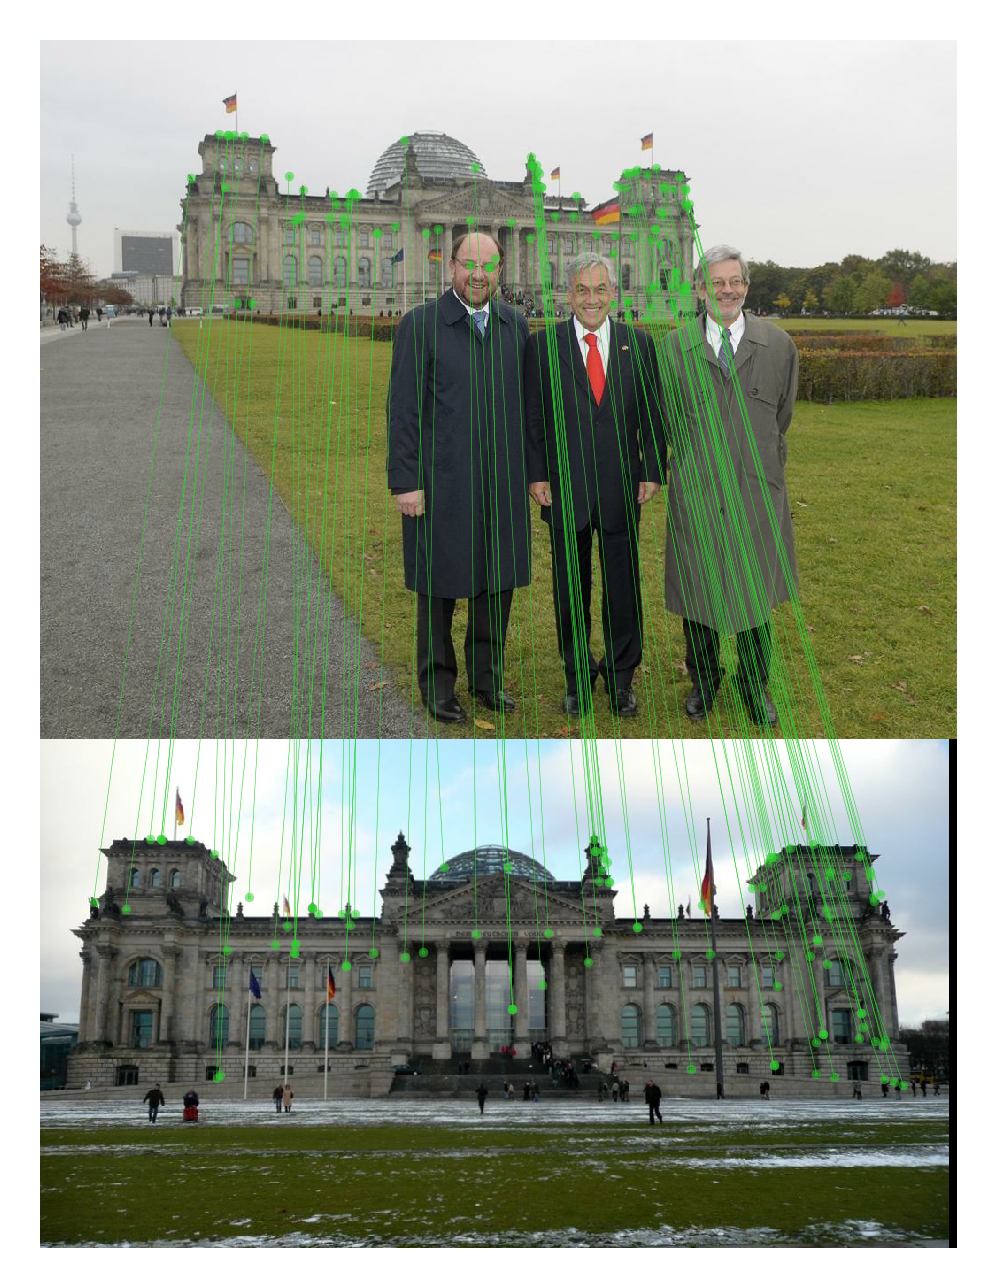

In [9]:
top_N = 100

# pad image if required
if im_1.shape[1]>im_2.shape[1]:
    im_2 = np.concatenate((im_2,np.zeros((im_2.shape[0],im_1.shape[1]-im_2.shape[1],3),
                           dtype=np.uint8)),axis=1)
elif im_1.shape[1]<im_2.shape[1]:
    im_1 = np.concatenate((im_1,np.zeros((im_1.shape[0],im_2.shape[1]-im_1.shape[1],3),
                           dtype=np.uint8)),axis=1)

# plot
plt.imshow(np.concatenate((im_1[:,:,[2,1,0]],im_2[:,:,[2,1,0]]),axis=0))
plt.scatter(kp1[:top_N,0],kp1[:top_N,1],0.5,c='limegreen',alpha=0.5)
plt.scatter(kp2[:top_N,0],im_1.shape[0]+kp2[:top_N,1],0.5,c='limegreen',alpha=0.5)
plt.plot(np.stack((kp1[:top_N,0],kp2[:top_N,0])),
         np.stack((kp1[:top_N,1],im_1.shape[0]+kp2[:top_N,1])),
         c='limegreen',
         linewidth=0.1)
plt.axis('off')
plt.gcf().set_dpi(400)